## Preprocessor

In [48]:
"""
returns - X, y, df_cols -
Tf_Features : Max TFIDF Features (100)
N_Gram : 1
Sample : Only Use 1000 submissions (True)
One_Hot : One Hot Encode (True)
            Label Encode (False)

Standard_Scale : Standard Scale (True)
                 MinMaxScalar  (False)
"""

'\nreturns - X, y, df_cols -\nTf_Features : Max TFIDF Features (100)\nN_Gram : 1\nSample : Only Use 1000 submissions (True)\nOne_Hot : One Hot Encode (True)\n            Label Encode (False)\n\nStandard_Scale : Standard Scale (True)\n                 MinMaxScalar  (False)\n'

In [49]:
Tf_Features = 100
#Sample = True
Sample = .1
One_Hot =  False
Standard_Scale = True
N_Gram = 1

#### Func

In [50]:
def cat_cleaner(df,col):
    """
    Takes in the df and the column containing messy, sub cats.

    pd.get_dummies:
       col                 A | A,B | B | B,A
    0|  A              0|  1    0    0    0
    1| A,B  -onehot->  1|  0    1    0    0
    2|  B              2|  0    0    1    0
    3| B,A             3|  0    0    0    1

    this:

       col                       A | B
    0|  A                    0|  1   0
    1| A,B  -cat_cleaner ->  1|  1   1
    2|  B                    2|  0   1
    3| B,A                   3|  1   1



    """
    def cat(text):
        text =[word for word in text.split(',')]
        text =[word.strip() for word in text]
        return(text)


    df[col] = df[col].astype('str')
    clean_cats = df[col].apply(lambda x:cat(x))
    p = pd.get_dummies(clean_cats.apply(pd.Series).stack()).sum(level=0).reset_index(drop=True)
    return p

def text_cleaner(text,all_stop):
    """
    clean_str = text_cleaner(dirty_string)
    """
    regex = re.compile('[%s]' % re.escape(string.punctuation))

    text = text.lower()
    text = text.replace('<!--DONOTREMOVEESSAYDIVIDER-->',' ')
    text = text.replace('\n' , ' ')
    text = regex.sub('',text)
    text = ' '.join([word for word in text.split() if word not in all_stop])
    return(text)

def plot_empties(bad_form):
    plt.figure(figsize=(15,15))

    i = 1
    for j in bad_form:
        plt.subplot(230+i)
        sns.heatmap(pd.DataFrame(bad_form[j].isnull().sum()/bad_form[j].shape[0]*100),
                    annot=True,cmap=sns.color_palette("cool"),linewidth=1,linecolor="white")
        plt.title(j)
        i+=1

    plt.subplots_adjust(wspace = 1.6)
    return

def compress(df,encode=[],num=[],byte_str = False):
    pre_ = df[num+encode].memory_usage(deep=True)

    for i in num:
        if df[i].astype(np.float16).memory_usage(deep=True)<df[i].memory_usage(deep=True):
            df[i] = df[i].astype(np.float16)
        else:
            pass

    if byte_str:
        for j in encode:
            if df[j].astype(np.string_).memory_usage(deep=True)<df[j].memory_usage(deep=True):
                df[j] = df[j].astype(np.string_)
            else:
                pass
    else:
        for j in encode:
            if df[j].astype(str).memory_usage(deep=True)<df[j].memory_usage(deep=True):
                df[j] = df[j].astype(str)
            else:
                pass



    post_ = df[num+encode].memory_usage(deep=True)
    print("Data Usage - change:{}".format((post_-pre_)))
    print("Total Change: {}".format((post_-pre_).sum()))
    return


### Imports

In [51]:
import gc
import re
import string
import calendar
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from nltk.corpus import stopwords

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer


In [5]:
bad_form = {#'Donations' : pd.read_csv('./Input/New/Donations.csv'),
            #'Donors'    : pd.read_csv('./Input/New/Donors.csv'),

            'Projects'  : pd.read_csv('./Input/New/Projects.csv'),
            'Resources' : pd.read_csv('./Input/New/Resources.csv'),
            'Schools'   : pd.read_csv('./Input/New/Schools.csv'),
            'Teachers'  : pd.read_csv('./Input/New/Teachers.csv')}


#### Null values from all data sources

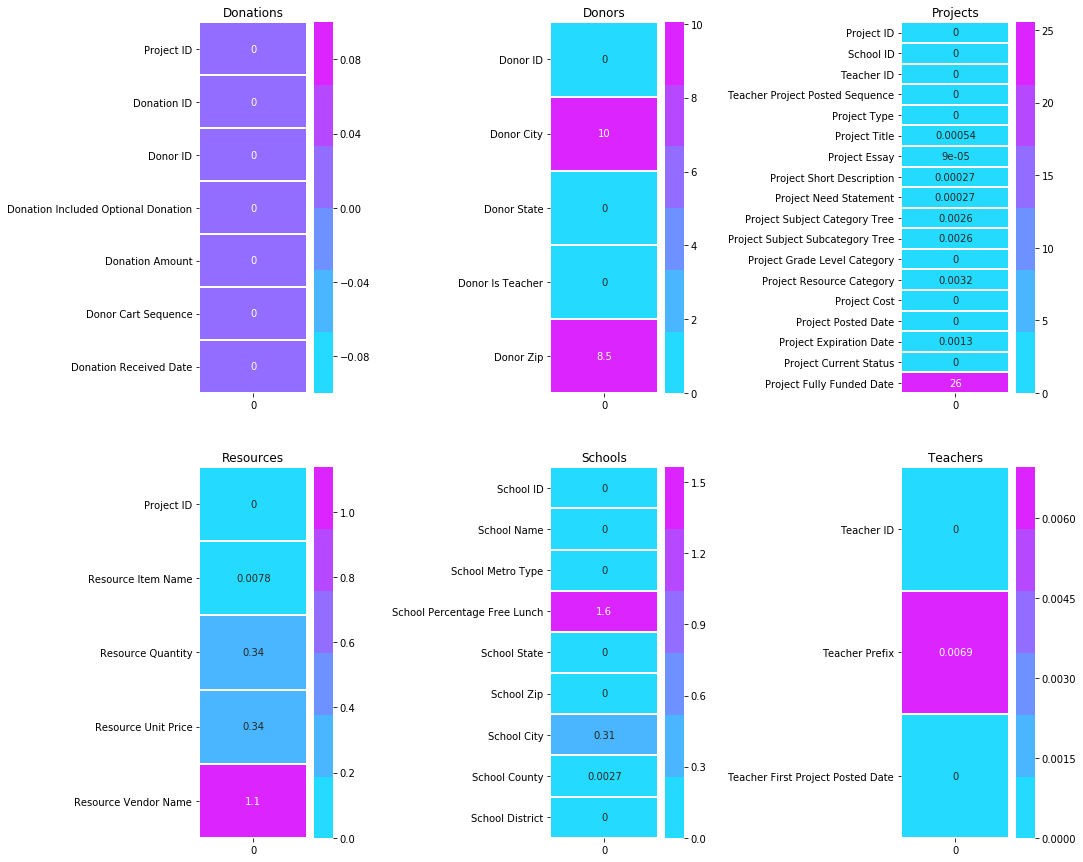

In [7]:
#plot_empties(bad_form)

## Donor Profiles

In [54]:
if False:
    bad_form['Donations'] = bad_form['Donations'][bad_form['Donations']['Donation Amount'] > 0.1]
    Donors = bad_form['Donations'].groupby('Donor ID').agg({'Donation ID': ['nunique'], 
         'Donation Amount': ['mean', 'sum','median','max','min','std']})

    Donors = bad_form['Donors'].merge(Donors, right_index=True, left_on='Donor ID').copy(deep=True)
    Donors['One Time Donor'] = Donors['Donations Count'].apply(lambda x: 1 if x == 1 else 0)
    Donors['Donation Std Amount'] = Donors['Donation Std Amount'].fillna(0)

    Donors.columns = ['Donor ID', 'Donor City', 'Donor State', 'Donor Is Teacher', 'Donor Zip', 'Donations Count', 
                    'Donation Mean Amount', 'Donation Sum Amount', 'Donation Median Amount', 'Donation Max Amount', 
                    'Donation Min Amount', 'Donation Std Amount', 'One Time Donor']

    Donors.to_csv('./Input/New/Donors.csv')

/Users/Nahel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Project Processing

### Treating Nulls in 'Teachers'

In [9]:
bad_form['Teachers']['Teacher Prefix'] = bad_form['Teachers']['Teacher Prefix'].apply(
    lambda x: 'Teacher' if x in ['Mx.', np.nan] else x)

for i in bad_form:
    bad_form[i] = bad_form[i].dropna()

### Data Aggregation


In [10]:
#How much of the data do you want to use?
df = bad_form['Projects'][:int(bad_form['Projects'].shape[0] * Sample)].copy(deep=True)
#if Sample: df = bad_form['Projects'][:1000].copy(deep=True)
#else: df = bad_form['Projects'].copy(deep=True)

### Projects

In [11]:

print('DataFrame Init')

#Structure Target
df['Project Current Status'] = df['Project Current Status'].apply(lambda x: 1 if x == 'Fully Funded' else 0)

#Adding dt features
df['Project Posted Date'] = pd.to_datetime(df['Project Posted Date'])
df['Project Posted Year'] = df['Project Posted Date'].dt.year.astype(str)
df['Project Posted Month'] = df['Project Posted Date'].dt.month
df['Project Posted Month'] = df['Project Posted Month'].apply(lambda x: calendar.month_abbr[x])

#cols
encode_cols = ['Project Type','Project Posted Year','Project Posted Month',
               'Project Grade Level Category','Project Resource Category',]
num_cols    = ['Project Cost']

#del
for i in ['Teacher Project Posted Sequence', 'Project Fully Funded Date', 
          'Project Expiration Date', 'Project Subject Subcategory Tree', 
          'Project Posted Date','Project Title','Project Short Description']:
    del df[i]
del calendar
gc.collect()

DataFrame Init


374

### Teachers



In [52]:
print('Merging Teacher Information')

#Treating Nulls in 'Teachers'
bad_form['Teachers']['Teacher Prefix'] = bad_form['Teachers']['Teacher Prefix'].apply(
    lambda x: 'Teacher' if x in ['Mx.', np.nan] else x)

#merging teacher to df
df = df.merge(bad_form['Teachers'],on='Teacher ID').copy(deep=True)

#cols
encode_cols += ['Teacher Prefix']
num_cols    += []

#del
for i in ['Teacher ID','Teacher First Project Posted Date']:
    del df[i]
#del bad_form['Teachers']
gc.collect()

Merging Teacher Information


KeyError: 'Teacher ID'

### School

In [ ]:
print('Merging School Information')

#very few, dropping nulls
bad_form['Schools'] = bad_form['Schools'].dropna()

#merging school to df
df = df.merge(bad_form['Schools'],on='School ID')
df['School Zip'] = df['School Zip'].astype(str)

#cols
encode_cols += ['School Metro Type','School State','School District','School Zip']
num_cols    += ['School Percentage Free Lunch']

#del
for i in ['School Name','School ID','School City','School County']:
    del df[i]
#del bad_form['Schools']
gc.collect()

### Resource Managment

In [12]:
print('Merging Resource Managment')

#more funding features
bad_form['Resources']['Resource Total Cost'] = bad_form['Resources']['Resource Quantity'] * bad_form['Resources']['Resource Unit Price']
funding_agg = bad_form['Resources'].groupby('Project ID').agg(
    {'Resource Item Name': ['nunique'], 
     'Resource Quantity': ['sum'], 
     'Resource Total Cost': ['mean', 'sum','median','max','min']})

funding_agg.columns = ['Project num Unique Resources',
                   'Total Resource Quantity', 
                   'Mean Resource Cost', 
                   'Total Project Cost',
                   'Median Resource Cost',
                   'Most exp Resource Cost',
                   'Least exp Resource Cost']

#cols
encode_cols += []
num_cols    += list(funding_agg.columns.values)

#merging funding to df
funding_agg.reset_index(inplace=True)
df = df.merge(funding_agg,on='Project ID')

del funding_agg, df['Project ID'], 
#del bad_form['Resources']
gc.collect()

Merging Teacher Information
Merging School Information
Merging Resource Managment


90

### Compression

In [14]:
print('Compressing Data')
compress(df,encode_cols,[])

del compress
gc.collect()

Compressing Data
Data Usage - change:Index                           0
Project Type                    0
Project Posted Year             0
Project Posted Month            0
Project Grade Level Category    0
Project Resource Category       0
Teacher Prefix                  0
School Metro Type               0
School State                    0
School District                 0
School Zip                      0
dtype: int64
Total Change: 0


40

### Encoding / Scaling


In [ ]:
#Preprocessing
print('Preprocessing')
df = df.dropna()

#Encoding
le_dict = {}
if One_Hot:
    df = df.merge(pd.get_dummies(df[encode_cols])
             ,left_index=True,right_index=True)
    for i in encode_cols:
        del df[i]
else:
    for c in encode_cols:
        encod = LabelEncoder()
        encod.fit(df[c].astype(str))
        df[c] = encod.transform(df[c].astype(str))
        le_dict[c] = dict(zip(encod.classes_, encod.transform(encod.classes_)))
    del encod

p = cat_cleaner(df,'Project Subject Category Tree')
df = df.merge(p,left_index=True,right_index=True)
#del df['Project Subject Category Tree'], p

#Scaling
df = df.dropna()

if Standard_Scale:
    Scalar = StandardScaler()
else:
    Scalar = MinMaxScaler()

df[num_cols] = Scalar.fit_transform(df[num_cols])

#del One_Hot, LabelEncoder, Standard_Scale, Scalar
#gc.collect()

### Text Editing

In [42]:
print('Text Processing')

text_cols = ['Project Essay','Project Need Statement']

#adding more words to 'stopwords'
extra_words = ['student','students','education']
single_l = [x for x in 'abcdefghijklmnopqrstuvwxyz']
for j in single_l:
    extra_words.append(j)
extra_words += stopwords.words("english")

for i in text_cols:
    df[i] = df[i].apply(lambda x: text_cleaner(x,extra_words))

del text_cleaner, extra_words, single_l, stopwords

Text Processing


### Tfidf

tfidf = TfidfVectorizer(max_features=Tf_Features, ngram_range=(1,N_Gram))
for i in text_cols:
    tfidf.fit(df[i])
    tf_cols = [str(i)+' contains: "'+str(x)+'"' for x in list(tfidf.vocabulary_.keys())]
    df = df.merge(pd.DataFrame(tfidf.transform(df[i]).todense(),columns=tf_cols), left_index=True, right_index=True)

for i in text_cols:
    del df[i]
del tfidf, tf_cols

In [54]:
X = df.drop(['Project Current Status'],axis=1)
y = df['Project Current Status']
df_cols = df.columns
#le_dict

## EDA

In [ ]:
Donors = pd.read_csv('./Input/New/Donors.csv')

In [55]:
Donors['Likely Organization'] = Donors.

,Unnamed: 0,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip,Donations Count,Donation Mean Amount,Donation Sum Amount,Donation Median Amount,Donation Max Amount,Donation Min Amount,Donation Std Amount,One Time Donor
0,0,00000ce845c00cbf0686c992fc369df4,Evanston,Illinois,No,602,1,50.000000,50.00,50.0,50.0,50.00,0.000000,1
1,1,00002783bc5d108510f3f9666c8b1edd,Appomattox,other,No,245,1,99.000000,99.00,99.0,99.0,99.00,0.000000,1
2,2,00002d44003ed46b066607c5455a999a,Winton,California,Yes,953,11,57.722727,634.95,26.0,150.0,9.69,52.200070,0
3,3,00002eb25d60a09c318efbd0797bffb5,Indianapolis,Indiana,No,462,5,42.000000,210.00,50.0,50.0,10.00,17.888544,0
4,4,0000300773fe015f870914b42528541b,Paterson,New Jersey,No,075,1,50.000000,50.00,50.0,50.0,50.00,0.000000,1


In [ ]:
Donors['Donation Mean Amount'].plot()